The datafiles contain pre-processed training and test data from the Ames housing dataset. Train a DT model predicting SalesPrice. First, create a HP grid with the *max_depth*, *min_samples_split* and *min_samples_leaf*, and try to come up with reasonable ranges for each of the HPs. Determine the best HP settings using Exhaustive Search and Bayesian Optimisation. For Bayesian Optimisation, use max 10 models. Compare on the results you obtain with the two types of grid searches. Comment on the degree of overfitting of the best models.

Some parts of the solution are already provided. Write code in the empty cells and in places indicated with "???".

Hint: use "HP tuning.ipynb" as an examples.

# Ensure skopt is installed

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme(palette="Set2")

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# increase column width
pd.set_option('display.max_colwidth', 250)

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load data

In [3]:
trainset = pd.read_csv("testset-ames-housing.csv")
testset = pd.read_csv("trainset-ames-housing.csv")

In [4]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        283 non-null    float64
 1   OverallCond    283 non-null    float64
 2   TotalBsmtSF    283 non-null    float64
 3   GrLivArea      283 non-null    float64
 4   FullBath       283 non-null    float64
 5   HalfBath       283 non-null    float64
 6   BedroomAbvGr   283 non-null    float64
 7   KitchenAbvGr   283 non-null    float64
 8   TotRmsAbvGrd   283 non-null    float64
 9   GarageArea     283 non-null    float64
 10  OpenPorchSF    283 non-null    float64
 11  EnclosedPorch  283 non-null    float64
 12  PoolArea       283 non-null    float64
 13  Age            283 non-null    float64
 14  MSZoning_FV    283 non-null    float64
 15  MSZoning_RH    283 non-null    float64
 16  MSZoning_RL    283 non-null    float64
 17  MSZoning_RM    283 non-null    float64
 18  MSZoning_n

In [5]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1109 non-null   float64
 1   OverallCond    1109 non-null   float64
 2   TotalBsmtSF    1109 non-null   float64
 3   GrLivArea      1109 non-null   float64
 4   FullBath       1109 non-null   float64
 5   HalfBath       1109 non-null   float64
 6   BedroomAbvGr   1109 non-null   float64
 7   KitchenAbvGr   1109 non-null   float64
 8   TotRmsAbvGrd   1109 non-null   float64
 9   GarageArea     1109 non-null   float64
 10  OpenPorchSF    1109 non-null   float64
 11  EnclosedPorch  1109 non-null   float64
 12  PoolArea       1109 non-null   float64
 13  Age            1109 non-null   float64
 14  MSZoning_FV    1109 non-null   float64
 15  MSZoning_RH    1109 non-null   float64
 16  MSZoning_RL    1109 non-null   float64
 17  MSZoning_RM    1109 non-null   float64
 18  MSZoning

# Separate predictors and target

In [6]:
ytrain = trainset["SalePrice"].copy()
Xtrain = trainset.drop("SalePrice", axis=1)
ytest = testset["SalePrice"].copy()
Xtest = testset.drop("SalePrice", axis=1)

# Create a tree with default HP settings

Train an unconstrained DT on the training data. Evaluate it using RMSE, and examine its depth.

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error

tree_reg = DecisionTreeRegressor(random_state=7)
tree_reg.fit(Xtrain, ytrain)
yhat = tree_reg.predict(Xtrain)
tree_rmse = root_mean_squared_error(ytrain, yhat)
tree_rmse

0.0

<Axes: >

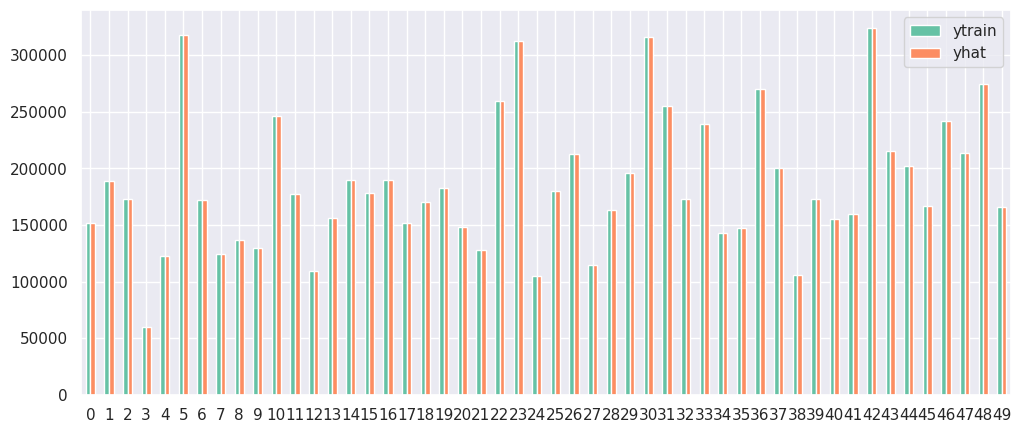

In [8]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [9]:
tree_reg.get_n_leaves()

np.int64(274)

In [10]:
# the depth of the tree
tree_reg.get_depth()

16

In [11]:
from sklearn.model_selection import cross_val_score

# Exhaustive search

In [12]:
from sklearn.model_selection import GridSearchCV

In [89]:
start = timer()

# specify the hyperparameters and their values
hp_grid = {
    'max_depth': [50, 100, 500, 1000, 5000],
    'min_samples_leaf': [50, 100, 500, 1000, 5000],
    'min_samples_split': [50, 100, 500, 1000, 5000],
    'max_leaf_nodes': [50, 100, 500, 1000, 5000, None]
}

tree_reg = DecisionTreeRegressor(random_state=7)

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(tree_reg, hp_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True, verbose=1)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 10 folds for each of 750 candidates, totalling 7500 fits
Execution time HH:MM:SS: 0:00:49.706100


In [90]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=50, max_leaf_nodes=50, min_samples_leaf=50,
                      min_samples_split=50, random_state=7)

In [91]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'max_depth': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
1,"{'max_depth': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 50, 'min_samples_split': 100}",57263.728309,59584.273779,-4.052383
25,"{'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
26,"{'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 50, 'min_samples_split': 100}",57263.728309,59584.273779,-4.052383
700,"{'max_depth': 5000, 'max_leaf_nodes': 5000, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
...,...,...,...,...
746,"{'max_depth': 5000, 'max_leaf_nodes': None, 'min_samples_leaf': 5000, 'min_samples_split': 100}",83505.407244,81946.966282,1.866276
747,"{'max_depth': 5000, 'max_leaf_nodes': None, 'min_samples_leaf': 5000, 'min_samples_split': 500}",83505.407244,81946.966282,1.866276
748,"{'max_depth': 5000, 'max_leaf_nodes': None, 'min_samples_leaf': 5000, 'min_samples_split': 1000}",83505.407244,81946.966282,1.866276
749,"{'max_depth': 5000, 'max_leaf_nodes': None, 'min_samples_leaf': 5000, 'min_samples_split': 5000}",83505.407244,81946.966282,1.866276


# Bayesian Optimisation

In [92]:
from skopt import BayesSearchCV

In [93]:
start = timer()

hp_grid = {
    'max_depth': [50, 100, 500, 1000, 5000],
    'min_samples_leaf': [50, 100, 500, 1000, 5000],
    'min_samples_split': [50, 100, 500, 1000, 5000],
    'max_leaf_nodes': [50, 100, 500, 1000, 5000, None]
}


opt_grid_search = BayesSearchCV(
     DecisionTreeRegressor(random_state=7),
     hp_grid,
     n_iter=30,
     random_state=7,
     scoring='neg_root_mean_squared_error',
     return_train_score=True,
     cv=10
)

np.int = int
opt_grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:44.795310


In [94]:
opt_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=5000, max_leaf_nodes=500, min_samples_leaf=50,
                      min_samples_split=50, random_state=7)

In [95]:
cv_results = pd.DataFrame(opt_grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
6,"{'max_depth': 5000, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
13,"{'max_depth': 50, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
14,"{'max_depth': 100, 'max_leaf_nodes': 50, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
15,"{'max_depth': 1000, 'max_leaf_nodes': None, 'min_samples_leaf': 50, 'min_samples_split': 100}",57263.728309,59584.273779,-4.052383
12,"{'max_depth': 1000, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
11,"{'max_depth': 100, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
29,"{'max_depth': 100, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 100}",57263.728309,59584.273779,-4.052383
23,"{'max_depth': 100, 'max_leaf_nodes': None, 'min_samples_leaf': 50, 'min_samples_split': 100}",57263.728309,59584.273779,-4.052383
24,"{'max_depth': 500, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 50}",57263.728309,59584.273779,-4.052383
26,"{'max_depth': 5000, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 100}",57263.728309,59584.273779,-4.052383


Evaluate on the test set

In [96]:
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_rmse = root_mean_squared_error(ytest, yhat)
final_rmse

57447.42054026047

<Axes: >

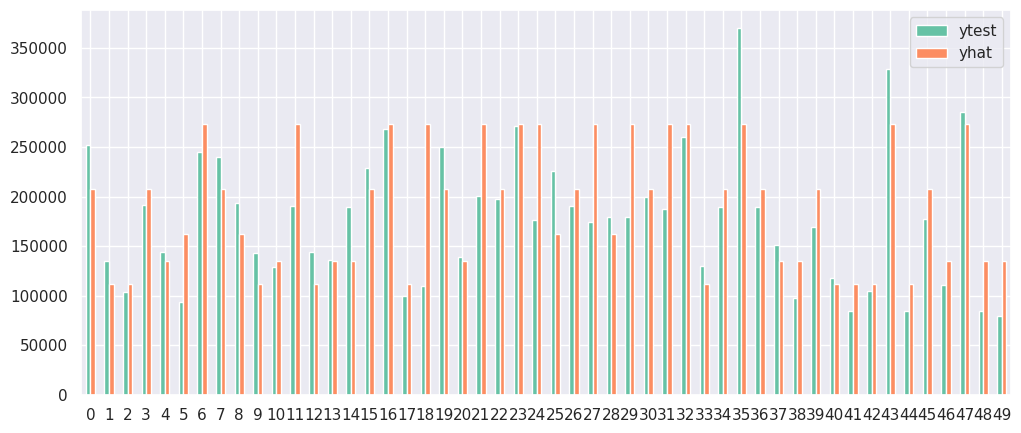

In [97]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytest": ytest[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

In [98]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

TotalBsmtSF: 0.766
GrLivArea: 0.182
Age: 0.052
TotRmsAbvGrd: 0.000
Street_nan: 0.000
Street_Pave: 0.000
PoolArea: 0.000
OverallCond: 0.000
OpenPorchSF: 0.000
MSZoning_nan: 0.000
MSZoning_RM: 0.000
MSZoning_RL: 0.000
MSZoning_RH: 0.000
MSZoning_FV: 0.000
LotArea: 0.000
KitchenAbvGr: 0.000
HalfBath: 0.000
GarageArea: 0.000
FullBath: 0.000
EnclosedPorch: 0.000
BedroomAbvGr: 0.000


In [99]:
from sklearn.inspection import permutation_importance

result = permutation_importance(grid_search.best_estimator_, Xtest, ytest,
                                n_repeats=10, random_state=7,
                                scoring='neg_root_mean_squared_error')

In [100]:
# raw permutation importance scores
sorted_importances_idx = result.importances_mean.argsort()
raw_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=Xtrain.columns[sorted_importances_idx],
)
raw_importances

,LotArea,OverallCond,HalfBath,FullBath,BedroomAbvGr,KitchenAbvGr,GarageArea,TotRmsAbvGrd,PoolArea,MSZoning_FV,...,EnclosedPorch,MSZoning_RH,MSZoning_nan,MSZoning_RM,MSZoning_RL,Street_nan,Street_Pave,Age,GrLivArea,TotalBsmtSF
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4416.884432,11746.118255,26762.776832
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4048.144857,11909.889676,24659.666445
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3837.306190,12679.370933,24106.873405
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3502.399380,11177.081587,24949.084306
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3395.310694,12477.312309,23194.741372
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3730.180434,11016.196629,24608.354902
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3827.410833,11378.761713,24070.641207
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3663.745196,11649.294055,23235.519167
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3377.572801,11308.928076,25109.526272
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3650.001097,11974.860013,23559.575414


In [101]:
result.importances_mean

array([    0.        ,     0.        , 24425.67593218, 11731.78132463,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,  3744.89559144,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ])

In [102]:
Xtest.columns

Index(['LotArea', 'OverallCond', 'TotalBsmtSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'GarageArea', 'OpenPorchSF', 'EnclosedPorch', 'PoolArea', 'Age',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'MSZoning_nan', 'Street_Pave', 'Street_nan'],
      dtype='object')

In [103]:
pd.Series(result.importances_mean, index=Xtest.columns).sort_values(ascending=False)

,0
TotalBsmtSF,24425.675932
GrLivArea,11731.781325
Age,3744.895591
OverallCond,0.000000
LotArea,0.000000
FullBath,0.000000
HalfBath,0.000000
KitchenAbvGr,0.000000
BedroomAbvGr,0.000000
GarageArea,0.000000
